# Keras 3 (JAX Backend) - Integrated Stacking Ensemble

This notebook demonstrates how to build a **Stacked Ensemble** using Keras 3 with the JAX backend, incorporating data processing and architectural patterns from production-style forecasting scripts.

The process involves:
1.  **Setting up Keras for JAX**.
2.  **Data Generation & Scaling**: Creating a synthetic dataset, normalizing it (MinMax), and windowing it using a sliding window approach.
3.  **Building 3 Base Models**: `SimpleRNN`, `LSTM`, and `GRU`.
4.  **Integrated Ensemble**: Instead of manually extracting features, we use the Keras Functional API to freeze the base models, concatenate their outputs, and feed them into a meta-learner within a single computational graph.
5.  **Evaluation**: Comparing RMSE scores.

In [1]:
import os
# 1. Setup JAX Backend
os.environ["KERAS_BACKEND"] = "jax"

import jax
import keras
from keras import layers
from keras import Model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Avoid GPU memory fragmentation
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

print(f"JAX version: {jax.__version__}")
print(f"Keras version: {keras.__version__}")

JAX version: 0.8.0
Keras version: 3.12.0


## Part 1: Data Preparation

We implement the `create_dataset` utility and normalization logic used in robust forecasting pipelines.

In [2]:
# 1. Generate Synthetic Data (Mimicking a single column time series like 'beer.csv')
def generate_synthetic_series(n_samples=2000):
    t = np.linspace(0, 100, n_samples)
    # Sine wave + trend + noise
    data = np.sin(t) + (t * 0.05) + np.random.normal(0, 0.1, t.shape)
    return data.reshape(-1, 1)

dataset = generate_synthetic_series()

# 2. Normalize the dataset (Crucial for RNNs)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# 3. Define Windowing Function
def create_dataset(dataset, back=1, forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - back - forward - 1):
        b = dataset[i:(i+back), 0]
        f = dataset[(i+back):(i+back+forward), 0]
        dataX.append(b)
        dataY.append(f)
    return np.array(dataX), np.array(dataY)

# 4. Train/Test Split
train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset_scaled),:]

# 5. Reshape Data
look_back = 12
look_forward = 1

trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# Reshape input to be [samples, time steps, features] as per script requirements
# Script Logic: (Batch, 1, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(f"Train X Shape: {trainX.shape}")
print(f"Train Y Shape: {trainY.shape}")

Train X Shape: (1326, 1, 12)
Train Y Shape: (1326, 1)


## Part 2: Train Base Models

We initialize and train SimpleRNN, LSTM, and GRU models individually.

In [3]:
models = []
BATCH_SIZE = 256
EPOCHS = 50 # Reduced for demo speed

# Common Input Shape
input_shape = (1, look_back)

# --- Model A: SimpleRNN ---
print("Training SimpleRNN...")
modelA = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.SimpleRNN(16),
    layers.Dense(8, activation='relu'),
    layers.Dense(look_forward, activation='linear')
], name="SimpleRNN_Base")
modelA.compile(loss='mean_squared_error', optimizer='adam')
modelA.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
models.append(modelA)

# --- Model B: LSTM ---
print("Training LSTM...")
modelB = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(16),
    layers.Dense(8, activation='relu'),
    layers.Dense(look_forward, activation='linear')
], name="LSTM_Base")
modelB.compile(loss='mean_squared_error', optimizer='adam')
modelB.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
models.append(modelB)

# --- Model C: GRU ---
print("Training GRU...")
modelC = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.GRU(16),
    layers.Dense(8, activation='relu'),
    layers.Dense(look_forward, activation='linear')
], name="GRU_Base")
modelC.compile(loss='mean_squared_error', optimizer='adam')
modelC.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
models.append(modelC)

print("Base models trained.")

Training SimpleRNN...
Training LSTM...
Training GRU...
Base models trained.


## Part 3: Evaluate Base Models

Check individual RMSE scores before ensembling.

In [4]:
for model in models:
    # Predict
    trainPredict = model.predict(trainX, verbose=0)
    testPredict = model.predict(testX, verbose=0)

    # Invert Scaling
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_inv = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY_inv = scaler.inverse_transform(testY)

    # Calculate RMSE
    trainScore = np.sqrt(mean_squared_error(trainY_inv, trainPredict))
    testScore = np.sqrt(mean_squared_error(testY_inv, testPredict))
    print(f"{model.name} -> Train RMSE: {trainScore:.2f}, Test RMSE: {testScore:.2f}")

SimpleRNN_Base -> Train RMSE: 0.20, Test RMSE: 0.62
LSTM_Base -> Train RMSE: 1.52, Test RMSE: 3.50
GRU_Base -> Train RMSE: 0.19, Test RMSE: 0.18


## Part 4: Build Integrated Ensemble Model

Here we implement the improved logic. Instead of creating a new dataset manually, we:
1.  Freeze the weights of the trained base models.
2.  Create a new Input layer.
3.  Pass that input through all base models to get their outputs.
4.  Concatenate outputs and pass them through a final Dense stack.

In [5]:
# 1. Freeze Base Models
for model in models:
    model.trainable = False

# 2. Build Functional API Graph
ensemble_input = layers.Input(shape=input_shape, name='ensemble_input')

# Feed input to all base models
# Note: Since base models are Sequential, we call them like functions on the input tensor
model_outputs = [model(ensemble_input) for model in models]

# 3. Concatenate Outputs
x = layers.Concatenate()(model_outputs)

# Optional Dropout for regularization
# x = layers.Dropout(0.2)(x)

# Meta-Learner Layers
x = layers.Dense(16, activation='relu')(x)
ensemble_output = layers.Dense(look_forward, activation='linear', name='final_output')(x)

# 4. Create Final Model
ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_output, name='Ensemble_Model')

ensemble_model.summary()

# 5. Compile and Train Meta-Learner
ensemble_model.compile(loss='mean_squared_error', optimizer='adam')

print("\nTraining Ensemble Model...")
ensemble_model.fit(trainX, trainY, epochs=1000, batch_size=256, verbose=0)

Model: "Ensemble_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ensemble_input      │ (None, 1, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SimpleRNN_Base      │ (None, 1)         │        609 │ ensemble_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Base           │ (None, 1)         │      2,001 │ ensemble_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU_Base            │ (None, 1)         │      1,585 │ ensemble_input[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ SimpleRNN_Base[0… │
│ (Concatenate)       │                   │            │ LSTM_Base[0][0],  │
│                     │                   │            │ GRU_Base[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │         64 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         17 │ dense_6[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,276 (16.70 KB)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 4,195 (16.39 KB)


Training Ensemble Model...


In [10]:
# Predict
trainPredict = ensemble_model.predict(trainX, verbose=0)
testPredict = ensemble_model.predict(testX, verbose=0)

# Invert Scaling
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform(testY)

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY_inv, trainPredict))
testScore = np.sqrt(mean_squared_error(testY_inv, testPredict))
print(f"Ensemble Model -> Train RMSE: {trainScore:.2f}, Test RMSE: {testScore:.2f}")

ens_train_pred=trainPredict
ens_test_pred=testPredict

ens_train_rmse=trainScore
ens_test_rmse=testScore


Ensemble Model -> Train RMSE: 0.18, Test RMSE: 0.48


## Part 5: Final Evaluation & Plotting

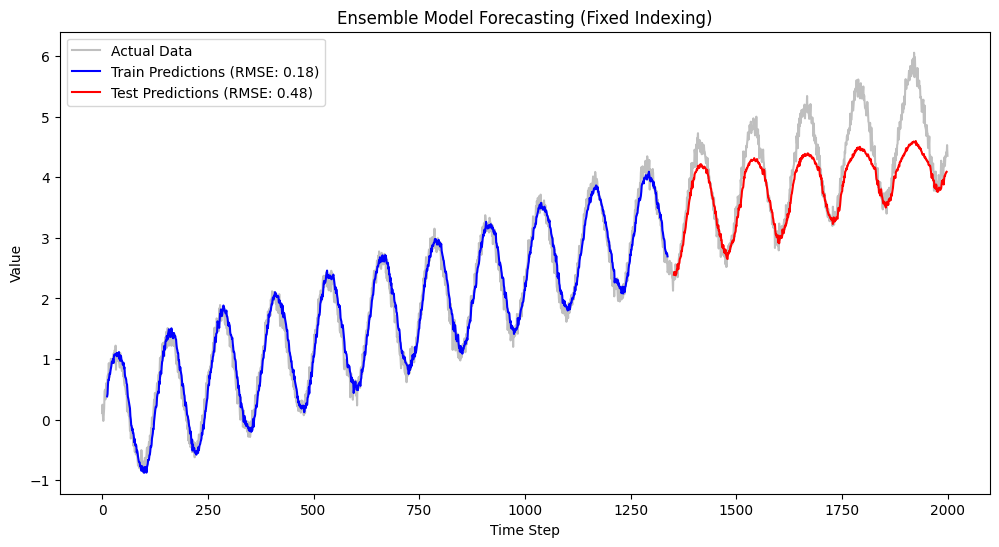

In [11]:
# 1. Prepare empty arrays matching the original dataset shape
trainPredictPlot = np.empty_like(dataset_scaled)
trainPredictPlot[:, :] = np.nan

testPredictPlot = np.empty_like(dataset_scaled)
testPredictPlot[:, :] = np.nan

# 2. Fill Train Predictions
# Train targets start at 'look_back' because the first window needs 'look_back' steps
train_start_idx = look_back
train_end_idx = train_start_idx + len(ens_train_pred)
trainPredictPlot[train_start_idx:train_end_idx, :] = ens_train_pred

# 3. Fill Test Predictions
# Test targets start at 'train_size + look_back'
# (Because test data starts at train_size, and we need look_back steps for the first prediction)
test_start_idx = train_size + look_back
test_end_idx = test_start_idx + len(ens_test_pred)

# Safe assignment using the calculated end index
testPredictPlot[test_start_idx:test_end_idx, :] = ens_test_pred

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(dataset_scaled), label='Actual Data', alpha=0.5, color='gray')
plt.plot(trainPredictPlot, label=f'Train Predictions (RMSE: {ens_train_rmse:.2f})', color='blue')
plt.plot(testPredictPlot, label=f'Test Predictions (RMSE: {ens_test_rmse:.2f})', color='red')
plt.title("Ensemble Model Forecasting (Fixed Indexing)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()